In [1]:
#import librairies 


from keras import backend as K
import tensorflow as tf
import pandas as pd 
import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import collections
import progressbar
import time
from time import process_time
import sys
import os
import random
import gc
    
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from imblearn.under_sampling import RandomUnderSampler 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import f1_score,classification_report,roc_auc_score,precision_score,recall_score, precision_recall_fscore_support 
from sklearn.model_selection import GridSearchCV,train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout

#from sklearn_som.som import SOM
import networkx as nx
from networkx.algorithms import approximation

pd.set_option('display.max_columns', 100)

from GEM.gem.utils      import graph_util, plot_util
from GEM.gem.evaluation import visualize_embedding as viz
from GEM.gem.evaluation import evaluate_graph_reconstruction as gr
from GEM.gem.embedding.gf       import GraphFactorization
#from GEM.gem.embedding.sdne     import SDNE
#from argparse import ArgumentParser
#from GraphEmbedding.ge import DeepWalk
#from GraphEmbedding.ge import SDNE
from karateclub.graph_embedding import Graph2Vec
from karateclub.node_embedding.neighbourhood import HOPE
from karateclub.node_embedding.neighbourhood import DeepWalk




num_frame=200#arbitraire , a tester plus serieusement

print("import terminé a :",time.strftime("%H:%M:%S", time.localtime()))

import terminé a : 09:50:25


In [2]:
#ce dictionaire contien le nom de chaques colones avec la valeur du f1_score
#qu'ils on obtenu apres etre ajouté au data_set
#initialisé a 0
#-1,name1,name2,w,b

def convert_dist_to_zero_and_ones(data_set_dist, threshold=0.3):
    new_data_set = data_set_dist < threshold
    return new_data_set.astype(int)

def create_pair_dict(columns_list=[]):
    if (columns_list==[]):
        print("you forgot to input a list of columns")
        return []
    pair_dict=dict()
    for name1 in columns_list:
        for name2 in columns_list:# oui ce n'est pas optimisé
            pair_names=name1+"_"+name2
            reverse_pair_names=name2+"_"+name1
            if name1!=name2 and pair_names not in pair_dict.keys() and reverse_pair_names not in pair_dict.keys():
                pair_dict[pair_names]=[-1,name1,name2,0,0]
    
    return pair_dict

def create_monstruous_pair_data_set_deprecated(pair_dict,panda_data_set):
    columns_list = panda_data_set.columns.tolist()
    if (columns_list==[]):
        print("you forgot to input a data_set")
        return {},[]
    if (pair_dict=={}):
        print("you forgot to input a dict")
        return {},[]
    #pair_dict=dict()
    process_bar = progressbar.ProgressBar().start(max_value=len(pair_dict));i=0
    monstruous_pair_data_set=[]
    for pair in pair_dict.items():
        pair_dict[pair[0]][0]=i
        #print(pair[1][0],pair[1][1],pair[1][2])# value name1,name2
        tmp_data_set=panda_data_set[[pair[1][1],pair[1][2]]]
        tmp_w,tmp_b=linear_regresion(tmp_data_set)
        pair_dict[pair[0]][3]=tmp_w
        pair_dict[pair[0]][4]=tmp_b
        monstruous_pair_data_set.append(distances(tmp_data_set,tmp_w,tmp_b))
        process_bar.update(i);i+=1
    #the monstruous data_set should contain 0 and 1
    return pair_dict,monstruous_pair_data_set

def create_monstruous_pair_data_set(pair_dict,panda_data_set):
    columns_list = panda_data_set.columns.tolist()
    if (columns_list==[]):
        print("you forgot to input a data_set")
        return {},[]
    if (pair_dict=={}):
        print("you forgot to input a dict")
        return {},[]
    #pair_dict=dict()
    process_bar = progressbar.ProgressBar().start(max_value=len(pair_dict));i=0
    monstruous_pair_data_set=np.array([])
    for pair in pair_dict.items():
        #print(pair[1][0],pair[1][1],pair[1][2])# id,name1,name2,w,b
        pair_dict[pair[0]][0]=i
        tmp_data_set=panda_data_set[[pair[1][1],pair[1][2]]]
        tmp_w,tmp_b=linear_regresion(tmp_data_set)
        pair_dict[pair[0]][3]=tmp_w
        pair_dict[pair[0]][4]=tmp_b
        
        if(monstruous_pair_data_set.size ==0):
            monstruous_pair_data_set=distances_expand(tmp_data_set,tmp_w,tmp_b)
        else:
            monstruous_pair_data_set=np.concatenate((monstruous_pair_data_set,distances_expand(tmp_data_set,tmp_w,tmp_b)),axis=1)
        process_bar.update(i);i+=1
    #the monstruous data_set should contain 0 and 1
    return pair_dict,monstruous_pair_data_set

def make_one_graph(line ,pair_dict):
    g=nx.Graph()
    
    for pair in pair_dict.items():
        #print(pair[1][0],pair[1][1],pair[1][2])# id,name1,name2,w,b
        i= pair[1][0]
        arc_val=line[i]

        if arc_val ==1:
            name_1=pair[1][1]
            name_2=pair[1][2]
            g.add_edge(name_1,name_2)
    
    return g

def create_graphs(monstruous_binary_np_data_set,pair_dict):
    start = time.time()
    graph_list=[]
    process_bar = progressbar.ProgressBar().start(max_value=len(monstruous_binary_np_data_set));i=0
   
    for line in monstruous_binary_np_data_set:
        #print(type(line),line.shape)

        graph_list.append( make_one_graph(line ,pair_dict))
        process_bar.update(i);i+=1
    print("---graph construction = %s seconds ---" % (time.time() - start));start = time.time()
 
    return graph_list

def save_np(np_array,name):
    if(".npy" not in name):
        print("you save a numpy array in a file.npy")
        return 0
    np.save(name, np_array)

def load_np(file_name):
    return np.load(file_name)

    
############################################## liste des options d'extractions
def graph_max_degree(g):
    degrees = [val for (node, val) in g.degree()]
    maxd=max(degrees)
    return maxd
def geodesic_dist(graph):
    return nx.average_shortest_path_length(graph)

#special thanks to Francisco A. Rodrigues, University of São Paulo.
# http://conteudo.icmc.usp.br/pessoas/francisco
def degree_distribution(G):
    vk = dict(G.degree())
    vk = list(vk.values()) # we get only the degree values
    maxk = np.max(vk)
    mink = np.min(min)
    kvalues= np.arange(0,maxk+1) # possible values of k
    Pk = np.zeros(maxk+1) # P(k)
    for k in vk:
        Pk[k] = Pk[k] + 1
    Pk = Pk/sum(Pk) # the sum of the elements of P(k) must to be equal to one
    return kvalues,Pk

def shannon_entropy(G):
    k,Pk = degree_distribution(G)
    H = 0
    for p in Pk:
        if(p > 0):
            H = H - p*math.log(p, 2)
    return H

def contain_meso_scale(graph):
    
    return False    




def extract_info_from_one_graph(g, to_do_list):
    graph_property=np.array([])
    calc_result=0
    
    if("max_degree" in to_do_list):
        #print (" max degree")
        calc_result=graph_max_degree(g)
        graph_property=np.append(graph_property,calc_result)
    if("assortativity" in to_do_list):
        calc_result = nx.degree_assortativity_coefficient(g)
        graph_property=np.append(graph_property,calc_result)
    if("clustering" in to_do_list):
        calc_result= approximation.average_clustering(g, trials=1000, seed=10)
        graph_property=np.append(graph_property,calc_result)
    if("global_efficiency" in to_do_list):
        calc_result= nx.global_efficiency(g)
        graph_property=np.append(graph_property,calc_result)   
    if("geodesic_dist" in to_do_list):
        if nx.is_connected(g):
            calc_result=geodesic_dist(g)
        else:
            calc_result=len(g.nodes()) # = la dist la plus grande
        graph_property=np.append(graph_property,calc_result)
    if("contain_meso_scale" in to_do_list):#to do
        calc_result=contain_meso_scale(g)
        graph_property=np.append(graph_property,calc_result)
    if("Shannon_entropy" in to_do_list):#to do
        calc_result=shannon_entropy(g)
        graph_property=np.append(graph_property,calc_result)  
    #change this ()
    #            ()
    #            ()
    #      to this ()()()
    return np.expand_dims(graph_property,axis=0)

def extract_info_from_graphs(graph_list, to_do_list):
    
    monstruous_info_data_set=np.array([])
    process_bar = progressbar.ProgressBar().start(max_value=len(graph_list));i=0
   
    
    for graph in graph_list:
        
        if(monstruous_info_data_set.size ==0):
            monstruous_info_data_set=extract_info_from_one_graph(graph, to_do_list)
        else:
            monstruous_info_data_set=np.concatenate((monstruous_info_data_set,extract_info_from_one_graph(graph, to_do_list)),axis=0)
        process_bar.update(i);i+=1
    
    return monstruous_info_data_set



def create_graphs_to_delete(monstruous_binary_np_data_set,pair_dict):
    start = time.time()
    graph_list=[]
    process_bar = progressbar.ProgressBar().start(max_value=len(monstruous_binary_np_data_set));i=0
   
    for line in monstruous_binary_np_data_set:
        #print(type(line),line.shape)

        graph_list.append( make_one_graph(line ,pair_dict))
        process_bar.update(i);i+=1
    print("---graph construction = %s seconds ---" % (time.time() - start));start = time.time()
    return False


def extract_info_from_binary_data_set(monstruous_binary_np_data_set,pair_dict, to_do_list):
    start_time = process_time() 
    process_bar = progressbar.ProgressBar().start(max_value=len(monstruous_binary_np_data_set));i=0
    monstruous_info_data_set=np.array([])
    counter = 0
    contruct_time=0
    calcul_time=0
    for line in monstruous_binary_np_data_set:
        in_loop_time = process_time()
        graph=make_one_graph(line ,pair_dict)
        contruct_time = contruct_time+ process_time()  - in_loop_time
        
        in_loop_time = process_time()
        if(monstruous_info_data_set.size ==0):
            monstruous_info_data_set=extract_info_from_one_graph(graph, to_do_list)
        else:
            monstruous_info_data_set=np.concatenate((monstruous_info_data_set,extract_info_from_one_graph(graph, to_do_list)),axis=0)
        calcul_time = calcul_time+ process_time()  - in_loop_time
        process_bar.update(i);i+=1
        
        #####################################################################
        del graph # je delete le graph pour etre sur de liberer la memoire
        #gc.collect() #je n'appelle pas le garbageColector = cout 22 heures
        #calcul_time =  521.984375 contruct_time 59.3125
        #counter=counter+1
        #if(counter == 100000):  
            #print(process_time()  - start_time, "seconds");start_time = process_time()
            #print("calcul_time = ",calcul_time,"contruct_time",contruct_time)
            #return monstruous_info_data_set
            
        
    
    print("---graph extraction = %s seconds ---" % (process_time()  - start_time));start_time = process_time()
    return monstruous_info_data_set

# Function to find distance line equation ax + by + c =0
#y=mx+c  ----> mx -y +c =0  ---> b=-1 ,a=weight ,c=bias
def shortest_distance(x1, y1, a, b, c):
    
    d = abs((a * x1 + b * y1 + c)) / (math.sqrt(a * a + b * b))
    #print("Perpendicular distance is ",d)
    return d

def distances(data_set,w,b):
    np_data=data_set.to_numpy()
    np_dist=[]
    for line in np_data:
        x1=line[0]
        y1=line[1]
        np_dist.append(shortest_distance(x1, y1, w, -1, b))
    
    return np.array(np_dist)

def distances_expand(data_set,w,b):
    np_data=data_set.to_numpy()
    np_dist=[]
    for line in np_data:
        x1=line[0]
        y1=line[1]
        np_dist.append(shortest_distance(x1, y1, w, -1, b))
    
    return np.expand_dims( np.array(np_dist)  ,axis=1)
# y = mx +b
def line_equation_from_two_points(x1,y1,x2,y2):
    m=(y2-y1)/(x2-x1)
    b=y1-m*x1
    return m,b



def shortest_distance_test():
    print(shortest_distance(0, 0, 1, -1, 1))
    print(shortest_distance(-1, 0, 1, -1, 1))
    print(shortest_distance(1, 0, 1, -1, 1))
    print(math.sqrt(2))
    print(shortest_distance(3, 0, 1, -1, 1))
    print(math.sqrt(2*2+2*2))


def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


def affiche_simple_graphique(threshold_list,recall,f1,title=""):
    %matplotlib inline
    plt.plot(threshold_list,f1,  label='F1 score',color="green")
    plt.plot(threshold_list,recall,  label='recall',color="darkgoldenrod")
    plt.plot(threshold_list,[x*0 for x in threshold_list],  label='water level',color="blue")
    plt.title(title)
    plt.legend()
    plt.show()
    gain_recall=sum(recall)/len(recall)
    gain_f1 = sum(f1)/len(f1)
    if(gain_recall>=0):
        print("average recall  ",'\033[92m'+"gain "+ '\033[0m',"%.4f" % gain_recall)
    else:
        print("average recall ",'\033[91m'+"loss "+ '\033[0m',"%.4f" % gain_recall)
    if(gain_f1>=0):
        print("average f1 score  ",'\033[92m'+"gain "+ '\033[0m',"%.4f" %gain_f1)
    else:
        print("average f1 score  ",'\033[91m'+"loss "+ '\033[0m',"%.4f" %gain_f1)




#https://www.machinelearningplus.com/deep-learning/linear-regression-tensorflow/
###############################################################################
################# partie linear regression ####################################
###############################################################################
###############################################################################
###############################################################################

def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

def lin_reg_bootstrap(panda_data_set,nb_iter=1000):
    columns_list = panda_data_set.columns.tolist()
    x_train=NormalizeData(panda_data_set[columns_list[0]].to_numpy())
    y_train=NormalizeData(panda_data_set[columns_list[1]].to_numpy())
    data_set_size=len(x_train)
    m=0
    b=0
    counter=0
    for i in range(nb_iter):
        p1=random.randint(0, data_set_size-1)
        p2=random.randint(0, data_set_size-1)
        
        x1=x_train[p1]
        y1=y_train[p1]        
        x2=x_train[p2]
        y2=y_train[p2]
        if((x2-x1)!=0):
            m_tmp,b_tmp=line_equation_from_two_points(x1,y1,x2,y2)
            m=m+m_tmp
            b=b+b_tmp
        else:
            counter=counter+1
    m=m/(nb_iter-counter)
    b=b/(nb_iter-counter)
    return m,b
    
def linreg(x,weight,bias):#x is a np list
    y = weight*x + bias
    return y

# Define loss function (MSE)
def squared_error(y_pred, y_true):
    return tf.reduce_mean(tf.square(y_pred - y_true))

def not_squared_error(y_pred, y_true):
    return tf.reduce_mean(y_pred - y_true)

def linear_regresion(panda_data_set,boot_iter=1000):
    columns_list = panda_data_set.columns.tolist()
    #x_train=panda_data_set[columns_list[0]].to_numpy()
    #y_train=panda_data_set[columns_list[1]].to_numpy()
    x_train=NormalizeData(panda_data_set[columns_list[0]].to_numpy())
    y_train=NormalizeData(panda_data_set[columns_list[1]].to_numpy())
    #print("x_train max =",np.amax(x_train, axis=0))
    #print("y_train max =",np.amax(y_train, axis=0))
    learning_rate = 0.01
    # Number of loops for training through all your data to update the parameters
    training_epochs = 100
    
    boot_weight,boot_bias=lin_reg_bootstrap(panda_data_set,nb_iter=boot_iter)
    weight = tf.Variable(boot_weight)
    bias   = tf.Variable(boot_bias)
    #weight = tf.Variable(0.)
    #bias   = tf.Variable(0.)
    
    
    for epoch in range(training_epochs):

        # Compute loss within Gradient Tape context
        with tf.GradientTape() as tape:
            y_predicted = linreg(x_train,weight,bias)
            #loss = squared_error(y_predicted, y_train)
            loss = not_squared_error(y_predicted, y_train)
            # Get gradients
            gradients = tape.gradient(loss, [weight,bias])

            # Adjust weights
            weight.assign_sub(gradients[0]*learning_rate)
            bias.assign_sub(gradients[1]*learning_rate)

    
    
    return weight.numpy(),bias.numpy()

print("fonctions declaré a :",time.strftime("%H:%M:%S", time.localtime()))



fonctions declaré a : 09:50:25


In [3]:
program_start = time.time()

In [4]:
#import le data_set complet --- import data_set = 28.00195622444153 seconds ---
start = time.time()

data_file= os.path.abspath('data')
full_path=data_file+'\\'+'fraudTrain.csv'   # unmodified train set
train_df=pd.read_csv(full_path)
full_path=data_file+'\\'+'fraudTest.csv'
test_df=pd.read_csv(full_path)



full_path=data_file+'\\'+'X_train_1_2_svm.csv'
xtrain_transformed_complique=pd.read_csv(full_path)
ytrain_transformed_complique=train_df['is_fraud'].iloc[:int(len(train_df)*0.8)]

full_path=data_file+'\\'+'X_val_1_2_svm.csv'
xval_transformed_complique=pd.read_csv(full_path)
yval_transformed_complique=train_df['is_fraud'].iloc[len(ytrain_transformed_complique):]


full_path=data_file+'\\'+'X_test_1_2_svm.csv'
xtest_transformed_complique=pd.read_csv(full_path)
ytest_transformed_complique=test_df['is_fraud']


xtrain_transformed_complique=xtrain_transformed_complique.drop(columns=['Unnamed: 0'])
xval_transformed_complique=xval_transformed_complique.drop(columns=['Unnamed: 0'])
xtest_transformed_complique=xtest_transformed_complique.drop(columns=['Unnamed: 0'])

cols = xtrain_transformed_complique.columns.tolist()
print(cols)
print("--- import data_set = %s seconds ---" % (time.time() - start));start = time.time()


['merchant', 'category', 'amt', 'gender', 'state', 'zip', 'lat', 'long', 'city_pop', 'dob', 'unix_time', 'merch_lat', 'merch_long', 'delta_time', 'delta_amt', 'delta_time_category', 'delta_amt_category', 'delta_time_merchant', 'delta_amt_merchant', 'avg_amt', 'delta_avg_amt', 'avg_amt_category', 'delta_avg_amt_category', 'avg_amt_merchant', 'avg_amt_state', 'avg_amt_city', 'avg_amt_job', 'delta_avg_amt_category_job', 'month', 'day', 'hour']
--- import data_set = 21.24168300628662 seconds ---


In [5]:
dict_378 = create_pair_dict(cols)
print (len(dict_378))
print(32*32)
print(len(cols))

465
1024
31


In [6]:
#create data_set  ---create_monstruous_pair_data_set = 0.00195622444153 seconds ---
start = time.time()
print("--- create_graph_dist = %s seconds ---" % (time.time() - start));start = time.time()


--- create_graph_dist = 0.0 seconds ---


In [7]:

print("--- convert_dist_to_zero_and_ones = %s seconds ---" % (time.time() - start));start = time.time()


--- convert_dist_to_zero_and_ones = 0.015925168991088867 seconds ---


In [8]:
#crash a 22% pour cause de memoire ?
#graph_list=create_graphs(M_le_binary,dict_378_binary)

# 1000 iter -->90 sec
#to_do_list=["max_degree","assortativity","clustering"]

# 1000 iter --> 91  sec
#to_do_list=["max_degree","assortativity","clustering","global_efficiency","geodesic_dist","Shannon_entropy"]


In [9]:
#WARNING:tensorflow:Early stopping conditioned on metric `Recall` which is not available. 
#Available metrics are: loss,f1,recall,val_loss,val_f1,val_recall

In [10]:
# manual f1 score 
from keras import backend as K
import tensorflow as tf
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import BatchNormalization


def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

#trouve le meilleur dict
def find_best_dict(dict_list):
    threshold=0.92
    while(threshold>0.50):
        tmp_list=list()
        for di in dict_list:
            precision=(di["1"]["precision"])
            if(precision>threshold):
                tmp_list.append(di)
        if(tmp_list):
            newlist = sorted(tmp_list, key=lambda d: d["1"]['f1-score'],reverse=True)
            print("choosen model precision: %.4f" %newlist[0]["1"]["precision"]," f1-score: %.4f" %newlist[0]["1"]['f1-score'])
            return newlist[0]
        threshold=threshold-0.04
    print("nothing good was found")
    return_value=sorted(dict_list, key=lambda d: d["1"]['f1-score'],reverse=True)
    return return_value[0]


def fixed_nn_exec_time(xtrain_transformed_complique,ytrain_transformed_complique ,
                        xtest_transformed_complique,ytest_transformed_complique ,
                        tmps_exec=30,max_iter=1000):
    start_function = time.time()
    results=[]
    curent_iter=0
    while((tmps_exec*60)>(time.time() - start_function)):
        model = Sequential()
        model.add(Dense(32, input_shape=(len(xtrain_transformed_complique.columns),),
                        activation='relu')),
        model.add(BatchNormalization()),
        model.add(Dense(16, activation='relu')),
        model.add(Dense(8, activation='relu')),
        model.add(Dropout(0.2)),
        model.add(Dense(4, activation='relu')),
        model.add(Dense(1, activation='sigmoid'))
        opt = tf.keras.optimizers.Adam(learning_rate=0.001) #optimizer
        los=tf.keras.losses.BinaryCrossentropy()
        model.compile(optimizer=opt, loss="binary_crossentropy", 
                      metrics=[tf.keras.metrics.Precision(),"accuracy",f1])

        history= model.fit(xtrain_transformed_complique, ytrain_transformed_complique
                           ,epochs = 10, batch_size=128, verbose = 0)
        history_dictict = history.history
        y_test_pred =(model.predict(xtest_transformed_complique) >0.5).astype("int32")
        print(classification_report(ytest_transformed_complique,y_test_pred))

        cl_nn=classification_report(ytest_transformed_complique,y_test_pred
                                    ,output_dict=True)
        results.append(cl_nn)

        curent_iter=curent_iter+1
        if curent_iter > max_iter:
            find_best_dict(results)
        
    return find_best_dict(results)

def dict_mean(d_list,target="1"):
    dict_list=list()
    mean_dict = {}
    if(target=="accuracy"):
        summ=0
        for d in d_list:
            summ=summ+d["accuracy"]
        return summ/len(d_list)
    else:
        for d in d_list:
            dict_list.append(d[target])#extract the lines i want
        for key in dict_list[0].keys():
            mean_dict[key] = sum(d[key] for d in dict_list) / len(dict_list)
    return mean_dict

def classification_mean(cl_list):
    avg_0 =dict_mean(cl_list,target="0")
    avg_1 =dict_mean(cl_list,target="1")
    avg_accuracy =dict_mean(cl_list,target="accuracy")
    avg_macro =dict_mean(cl_list,target="macro avg")
    avg_weighted =dict_mean(cl_list,target="weighted avg")
    return { "0": avg_0 ,"1":avg_1,"accuracy":avg_accuracy ,"macro avg":avg_macro,"weighted avg":avg_weighted } 

def fixed_nn_exec_time2(xtrain_transformed_complique,ytrain_transformed_complique ,
                        xtest_transformed_complique,ytest_transformed_complique ,
                        tmps_exec=30,max_iter=1000):
    start_function = time.time()
    results=[]
    curent_iter=0
    while((tmps_exec*60)>(time.time() - start_function)):
        model = Sequential()
        model.add(Dense(32, input_shape=(len(xtrain_transformed_complique.columns),),
                        activation='relu')),
        model.add(BatchNormalization()),
        model.add(Dense(16, activation='relu')),
        model.add(Dense(8, activation='relu')),
        model.add(Dropout(0.2)),
        model.add(Dense(4, activation='relu')),
        model.add(Dense(1, activation='sigmoid'))
        opt = tf.keras.optimizers.Adam(learning_rate=0.001) #optimizer
        los=tf.keras.losses.BinaryCrossentropy()
        model.compile(optimizer=opt, loss="binary_crossentropy", 
                      metrics=[tf.keras.metrics.Precision(),"accuracy",f1])

        history= model.fit(xtrain_transformed_complique, ytrain_transformed_complique
                           ,epochs = 10, batch_size=128, verbose = 0)
        history_dictict = history.history
        y_test_pred =(model.predict(xtest_transformed_complique) >0.5).astype("int32")
        print(classification_report(ytest_transformed_complique,y_test_pred))

        cl_nn=classification_report(ytest_transformed_complique,y_test_pred
                                    ,output_dict=True)
        results.append(cl_nn)

        curent_iter=curent_iter+1
        if curent_iter > max_iter:
            find_best_dict(results)
        
    return find_best_dict(results),classification_mean(results)


print("nn fonctions declaré a :",time.strftime("%H:%M:%S", time.localtime()))


nn fonctions declaré a : 09:50:46


In [11]:

cl_nn=fixed_nn_exec_time(xtrain_transformed_complique,ytrain_transformed_complique ,
                        xtest_transformed_complique,ytest_transformed_complique ,
                        tmps_exec=30,max_iter=100)
#print(cl_nn)

print("---NN sans ajout = %s seconds ---" % (time.time() - start));start = time.time()


              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.91      0.72      0.81      2145

    accuracy                           1.00    555719
   macro avg       0.96      0.86      0.90    555719
weighted avg       1.00      1.00      1.00    555719

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.91      0.80      0.85      2145

    accuracy                           1.00    555719
   macro avg       0.95      0.90      0.93    555719
weighted avg       1.00      1.00      1.00    555719

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.91      0.79      0.85      2145

    accuracy                           1.00    555719
   macro avg       0.95      0.90      0.92    555719
weighted avg       1.00      1.00      1.00    555719

              preci

In [12]:
print(cl_nn)

{'0': {'precision': 0.9990812158276368, 'recall': 0.9998374201100485, 'f1-score': 0.9994591749302749, 'support': 553574}, '1': {'precision': 0.947856315179606, 'recall': 0.7627039627039627, 'f1-score': 0.8452596228364763, 'support': 2145}, 'accuracy': 0.9989221171131453, 'macro avg': {'precision': 0.9734687655036214, 'recall': 0.8812706914070056, 'f1-score': 0.9223593988833756, 'support': 555719}, 'weighted avg': {'precision': 0.9988834946558036, 'recall': 0.9989221171131453, 'f1-score': 0.9988639855643522, 'support': 555719}}


In [13]:
#print(sorted(percent_ytest_pred,reverse=True)[0:10])

In [14]:
cl_nn2=fixed_nn_exec_time(xtrain_transformed_complique,ytrain_transformed_complique ,
                        xtest_transformed_complique,ytest_transformed_complique ,
                        tmps_exec=1,max_iter=1)
print(cl_nn2)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.90      0.80      0.85      2145

    accuracy                           1.00    555719
   macro avg       0.95      0.90      0.92    555719
weighted avg       1.00      1.00      1.00    555719

choosen model precision: 0.9028  f1-score: 0.8491
{'0': {'precision': 0.9992307900652745, 'recall': 0.9996658080039886, 'f1-score': 0.9994482516983643, 'support': 553574}, '1': {'precision': 0.9028361344537815, 'recall': 0.8013986013986014, 'f1-score': 0.8490985428500865, 'support': 2145}, 'accuracy': 0.9989005234659963, 'macro avg': {'precision': 0.951033462259528, 'recall': 0.900532204701295, 'f1-score': 0.9242733972742254, 'support': 555719}, 'weighted avg': {'precision': 0.9988587197630414, 'recall': 0.9989005234659963, 'f1-score': 0.9988679222054379, 'support': 555719}}


In [15]:
xgboost_results=[]
nn_results=[]
rf_results=[]
svm_results=[]
to_do_list=["max_degree","assortativity","clustering",
            "global_efficiency","geodesic_dist","Shannon_entropy"]

threshold_list=[0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6]



for treshold_value in threshold_list:
    start = time.time()
    print("debut du treshold " ,treshold_value)
    
    name="data/"+"train_graph_properties"+str(treshold_value)+".npy"
    loaded_np=np.load(name)
    df_addon = pd.DataFrame(loaded_np, columns = to_do_list)
    X_train_plus_graph_df=pd.concat([xtrain_transformed_complique,df_addon],axis=1)
    X_train_plus_graph =np.concatenate((xtrain_transformed_complique,loaded_np),axis=1)


    name="data/"+"val_graph_properties"+str(treshold_value)+".npy"
    loaded_np=np.load(name)
    df_addon = pd.DataFrame(loaded_np, columns = to_do_list)
    X_val_plus_graph_df=pd.concat([xval_transformed_complique,df_addon],axis=1)
    X_val_plus_graph =np.concatenate((xval_transformed_complique,loaded_np),axis=1)

    name="data/"+"test_graph_properties"+str(treshold_value)+".npy"
    loaded_np=np.load(name)
    df_addon = pd.DataFrame(loaded_np, columns = to_do_list)
    X_test_plus_graph_df=pd.concat([xtest_transformed_complique,df_addon],axis=1)
    X_test_plus_graph =np.concatenate((xtest_transformed_complique,loaded_np),axis=1)
    
    
    print("---loading data = %s seconds ---" % (time.time() - start));start = time.time()
    #################### loading data finished 
    


    print("start nn") 
    nn_res=fixed_nn_exec_time(X_train_plus_graph_df,ytrain_transformed_complique ,
                        X_test_plus_graph_df,ytest_transformed_complique ,
                        tmps_exec=30)
    nn_results.append(nn_res)
    print("---neural network = %s seconds ---" % (time.time() - start));start = time.time()
    


    print("treshold " ,treshold_value," terminé a :",time.strftime("%H:%M:%S", time.localtime()))
    print("-----------------------------------------------------------------------------------------")
    

debut du treshold  0.2
---loading data = 0.4412059783935547 seconds ---
start nn
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.83      0.81      0.82      2145

    accuracy                           1.00    555719
   macro avg       0.91      0.90      0.91    555719
weighted avg       1.00      1.00      1.00    555719

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.92      0.74      0.82      2145

    accuracy                           1.00    555719
   macro avg       0.96      0.87      0.91    555719
weighted avg       1.00      1.00      1.00    555719

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.90      0.73      0.81      2145

    accuracy                           1.00    555719
   macro avg       0.95      0.87      0.90    

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.91      0.74      0.82      2145

    accuracy                           1.00    555719
   macro avg       0.95      0.87      0.91    555719
weighted avg       1.00      1.00      1.00    555719

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.91      0.74      0.82      2145

    accuracy                           1.00    555719
   macro avg       0.96      0.87      0.91    555719
weighted avg       1.00      1.00      1.00    555719

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.90      0.76      0.83      2145

    accuracy                           1.00    555719
   macro avg       0.95      0.88      0.91    555719
weighted avg       1.00      1.00      1.00    555719

              preci

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.91      0.76      0.83      2145

    accuracy                           1.00    555719
   macro avg       0.96      0.88      0.92    555719
weighted avg       1.00      1.00      1.00    555719

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.87      0.78      0.83      2145

    accuracy                           1.00    555719
   macro avg       0.94      0.89      0.91    555719
weighted avg       1.00      1.00      1.00    555719

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.87      0.79      0.83      2145

    accuracy                           1.00    555719
   macro avg       0.93      0.90      0.91    555719
weighted avg       1.00      1.00      1.00    555719

              preci

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.77      0.75      0.76      2145

    accuracy                           1.00    555719
   macro avg       0.89      0.87      0.88    555719
weighted avg       1.00      1.00      1.00    555719

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.84      0.77      0.81      2145

    accuracy                           1.00    555719
   macro avg       0.92      0.88      0.90    555719
weighted avg       1.00      1.00      1.00    555719

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.77      0.83      0.80      2145

    accuracy                           1.00    555719
   macro avg       0.88      0.92      0.90    555719
weighted avg       1.00      1.00      1.00    555719

choosen model preci

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.88      0.77      0.82      2145

    accuracy                           1.00    555719
   macro avg       0.94      0.89      0.91    555719
weighted avg       1.00      1.00      1.00    555719

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.75      0.80      0.78      2145

    accuracy                           1.00    555719
   macro avg       0.87      0.90      0.89    555719
weighted avg       1.00      1.00      1.00    555719

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.59      0.79      0.68      2145

    accuracy                           1.00    555719
   macro avg       0.80      0.89      0.84    555719
weighted avg       1.00      1.00      1.00    555719

              preci

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.70      0.73      0.71      2145

    accuracy                           1.00    555719
   macro avg       0.85      0.86      0.86    555719
weighted avg       1.00      1.00      1.00    555719

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.92      0.72      0.81      2145

    accuracy                           1.00    555719
   macro avg       0.96      0.86      0.90    555719
weighted avg       1.00      1.00      1.00    555719

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.49      0.73      0.58      2145

    accuracy                           1.00    555719
   macro avg       0.74      0.86      0.79    555719
weighted avg       1.00      1.00      1.00    555719

              preci

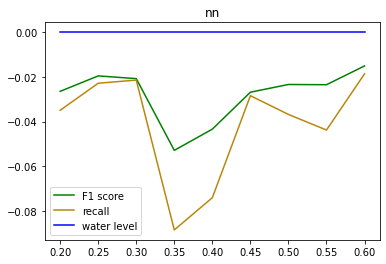

average recall  loss  -0.0411
average f1 score   loss  -0.0280
----------------------------------------------------------


In [16]:


nn_recalls=[]
nn_f1=[]
for cl2 in nn_results:
    recall_diff=(cl2["1"]["recall"]-cl_nn["1"]["recall"])
    f1_diff=(cl2["1"]["f1-score"]-cl_nn["1"]["f1-score"])
    nn_recalls.append(recall_diff)
    nn_f1.append(f1_diff)
affiche_simple_graphique(threshold_list,nn_recalls,nn_f1,
                         title="nn")
print("----------------------------------------------------------") 


In [17]:
################### big exec ###########################################
########################################################################
########################################################################
########################################################################
########################################################################
########################################################################
########################################################################
########################################################################
########################################################################
########################################################################
########################################################################
########################################################################
